In [13]:
from fourrooms import FourRooms
from collections import defaultdict
from time import sleep
from IPython.display import clear_output
import numpy as np
import math

# from IPython.display import clear_output
# import matplotlib.pyplot as plt

from utility import SoftmaxPolicy, SigmoidTermination, EpsGreedyPolicy, Critic
from agent_utils import compute_eval_gamma_interval

env = FourRooms()
env.reset()

(5, 8)

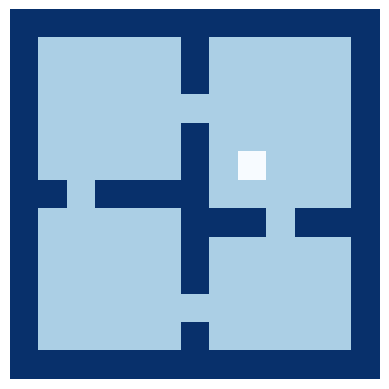

In [14]:
import matplotlib.pyplot as plt
env.goal = (2,4)
plt.imshow(env.render(show_goal=False), cmap='Blues')
plt.axis('off')
plt.show()


In [25]:
# Hyperparameters

# Discount
discount = 0.99

# Learning rates - termination, intra-option, critic
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5
eta = 0.020

# Epsilon for epsilon-greedy for policy over options
epsilon = 1e-1

# Temperature for softmax
temperature = 1e-2

# Number of runs
nruns = 10

# Number of episodes per run
nepisodes = 2500

# Maximum number of steps per episode
nsteps = 1000

# Number of options
noptions = 4

Goal:  (11, 5)
New goal:  (10, 6)
New goal:  (7, 9)
New goal:  (7, 9)


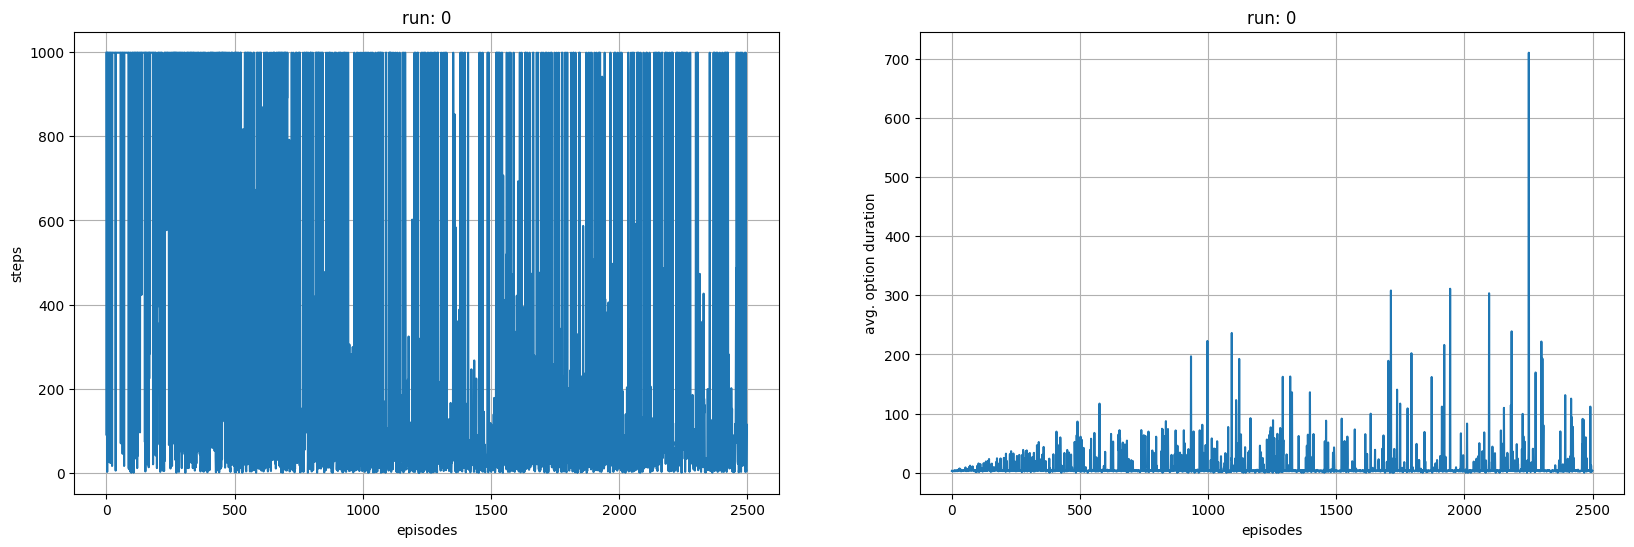

Goal:  (11, 5)
New goal:  (6, 2)
New goal:  (6, 2)
New goal:  (6, 2)


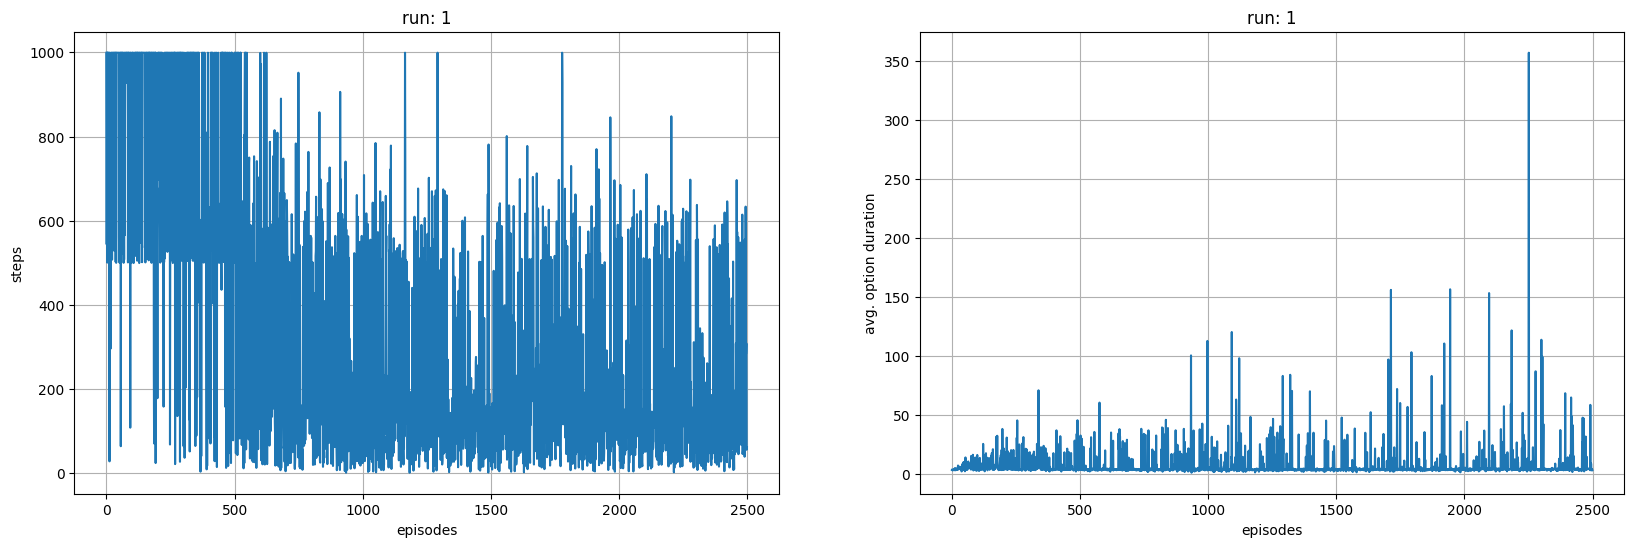

Goal:  (11, 5)
New goal:  (3, 6)
New goal:  (6, 2)
New goal:  (6, 2)


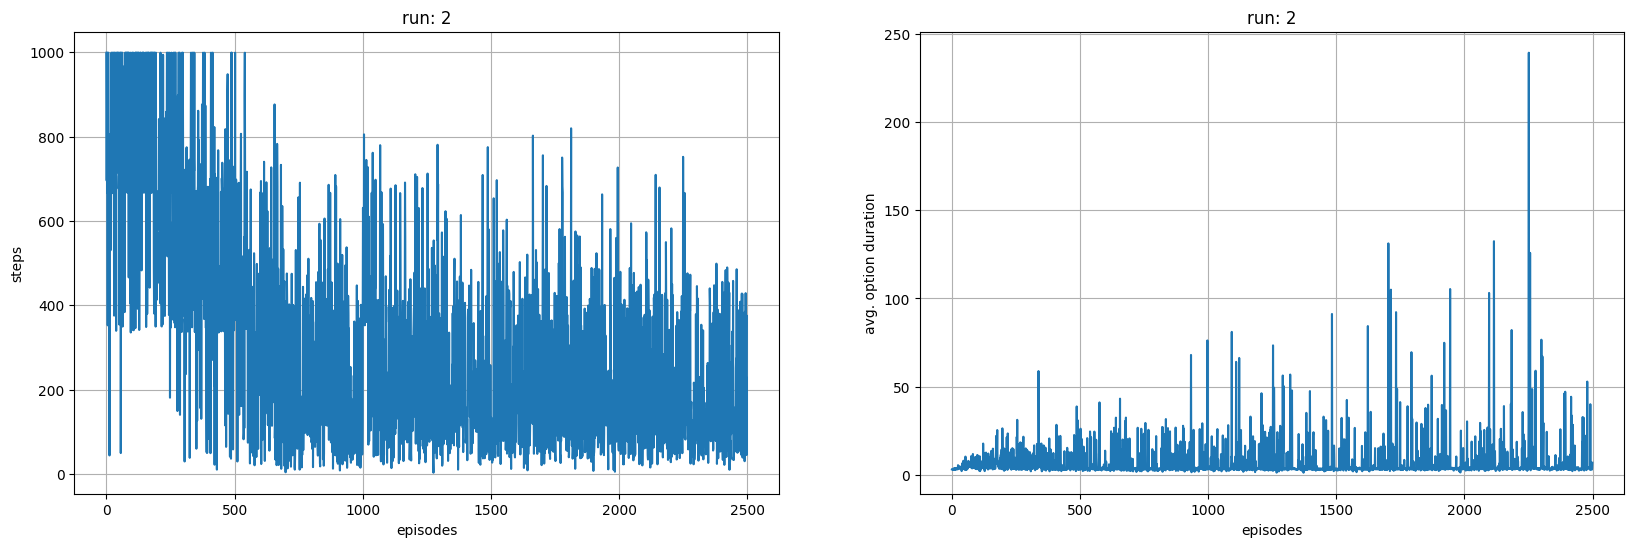

Goal:  (11, 5)
New goal:  (10, 6)
New goal:  (6, 2)
New goal:  (7, 9)


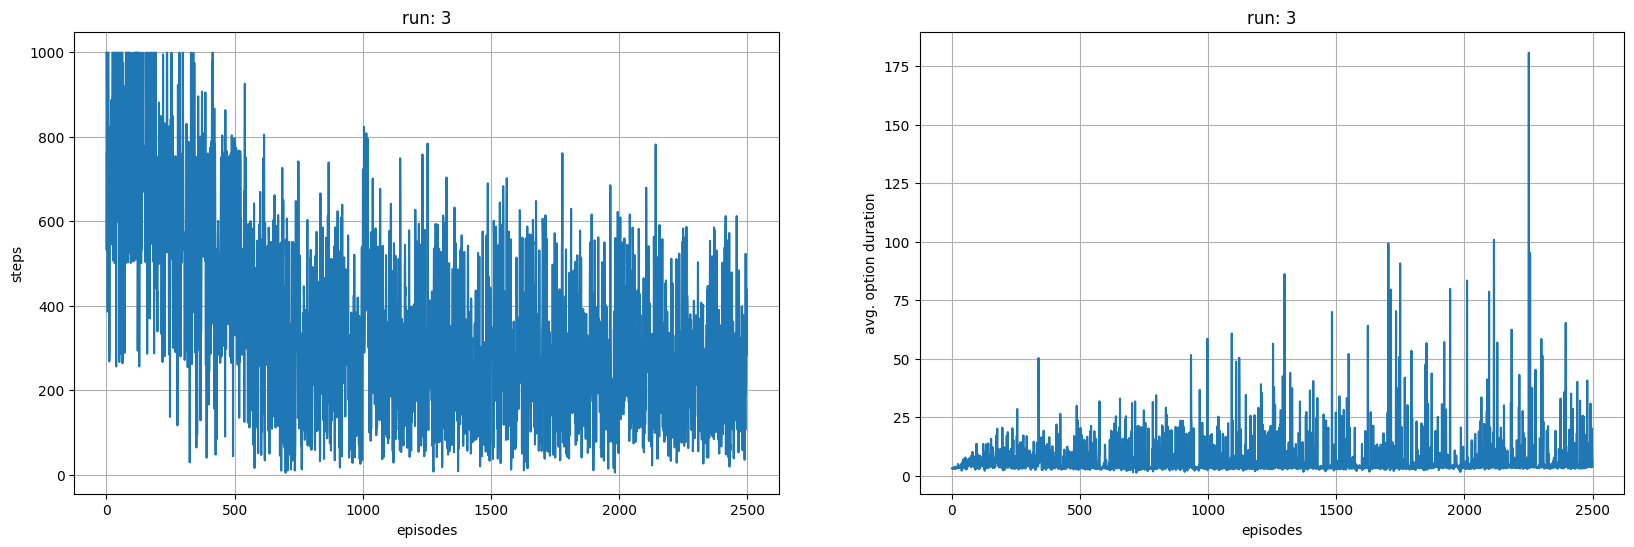

Goal:  (11, 5)
New goal:  (3, 6)
New goal:  (7, 9)
New goal:  (7, 9)


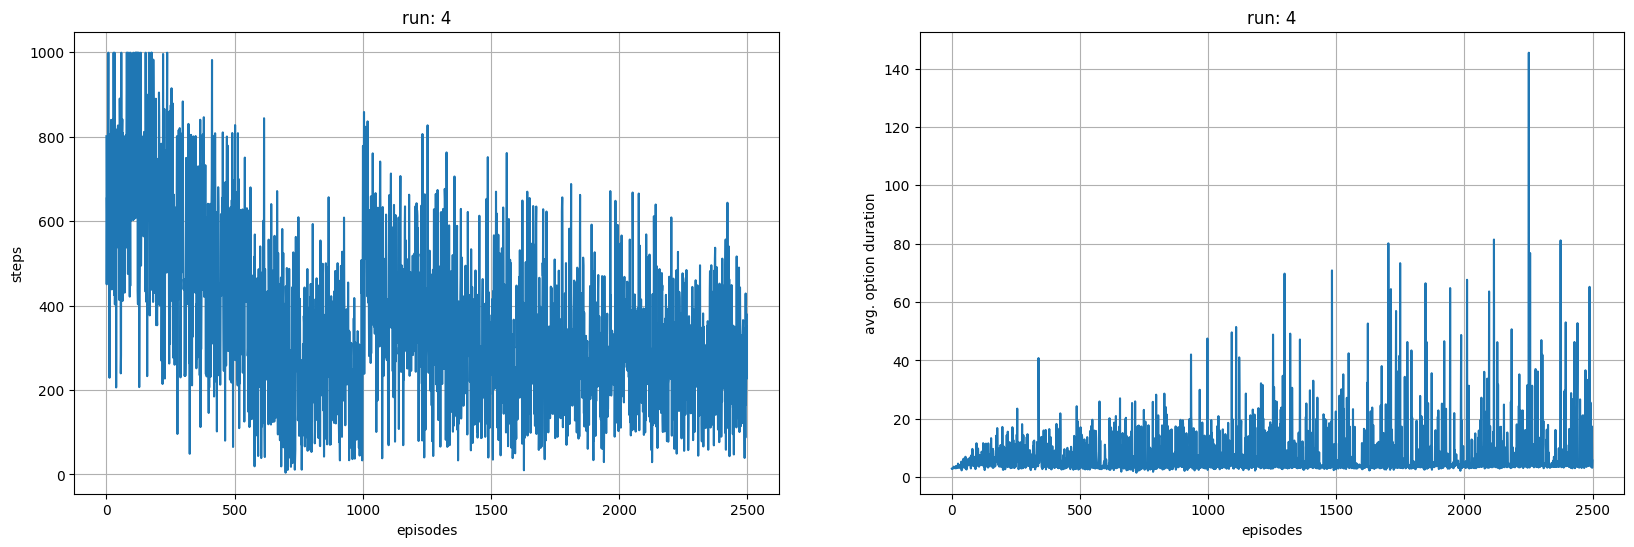

Goal:  (11, 5)
New goal:  (10, 6)
New goal:  (6, 2)
New goal:  (7, 9)


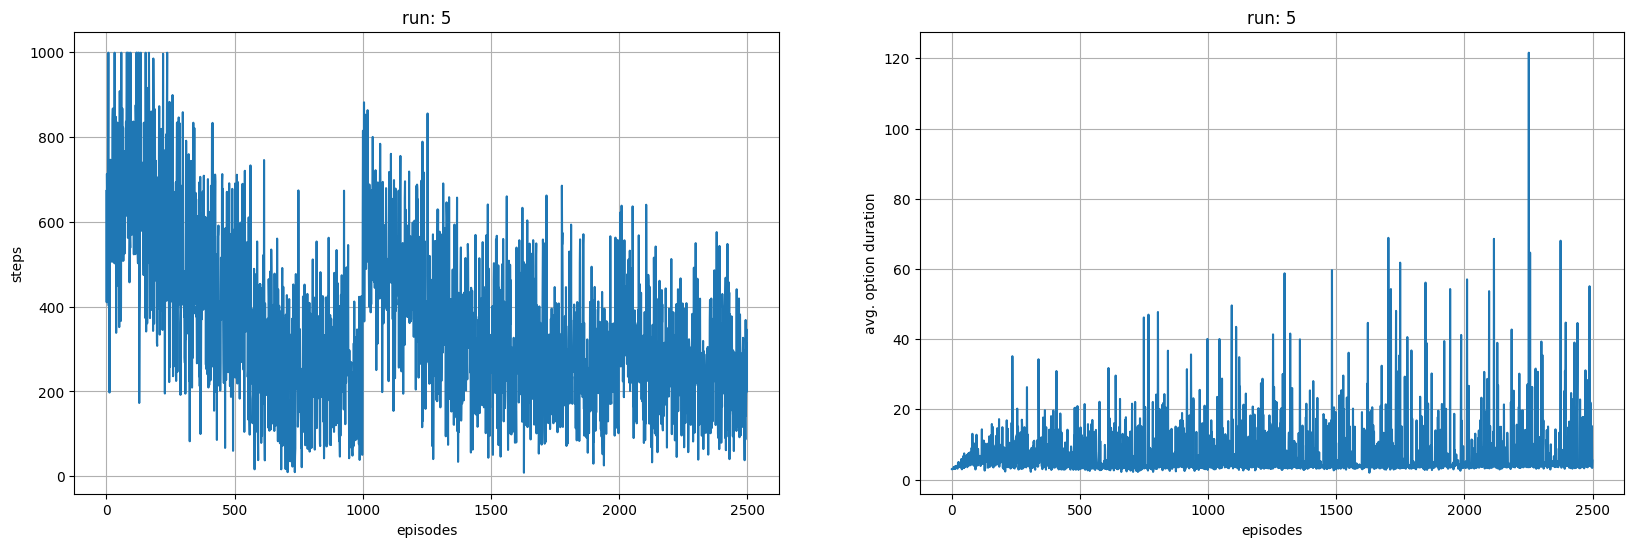

Goal:  (11, 5)
New goal:  (10, 6)
New goal:  (10, 6)
New goal:  (7, 9)


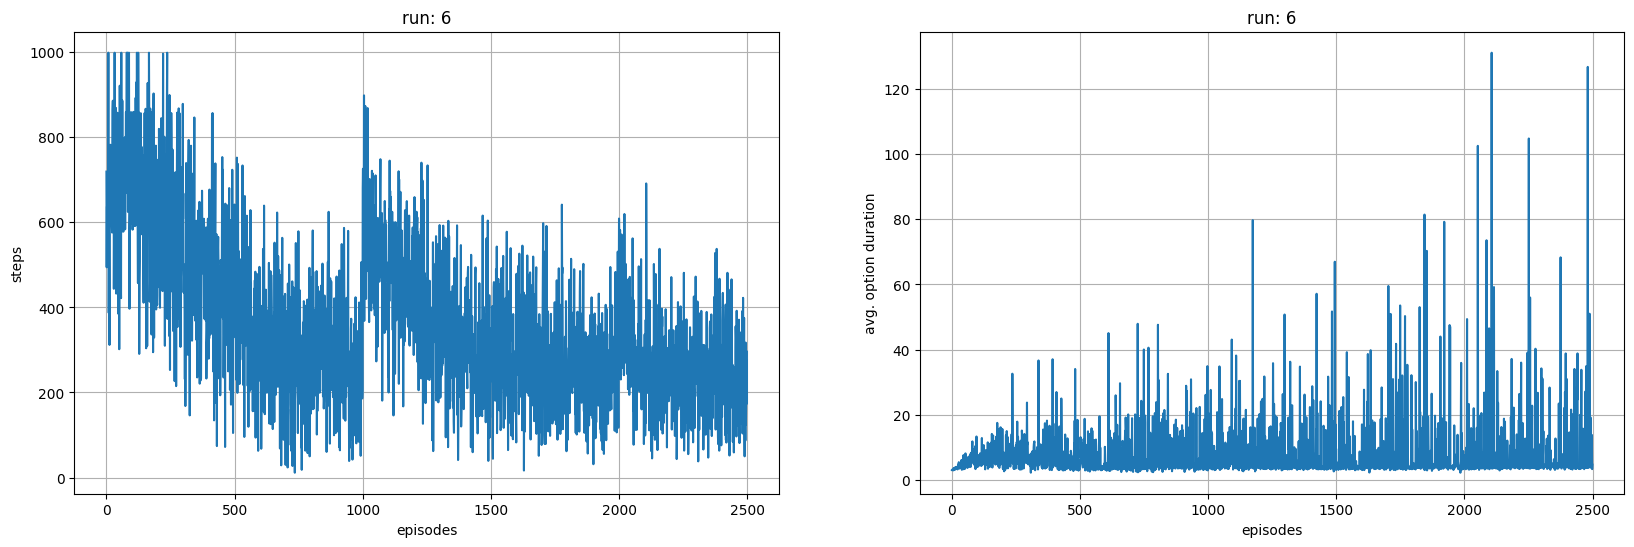

Goal:  (11, 5)
New goal:  (3, 6)
New goal:  (3, 6)
New goal:  (3, 6)


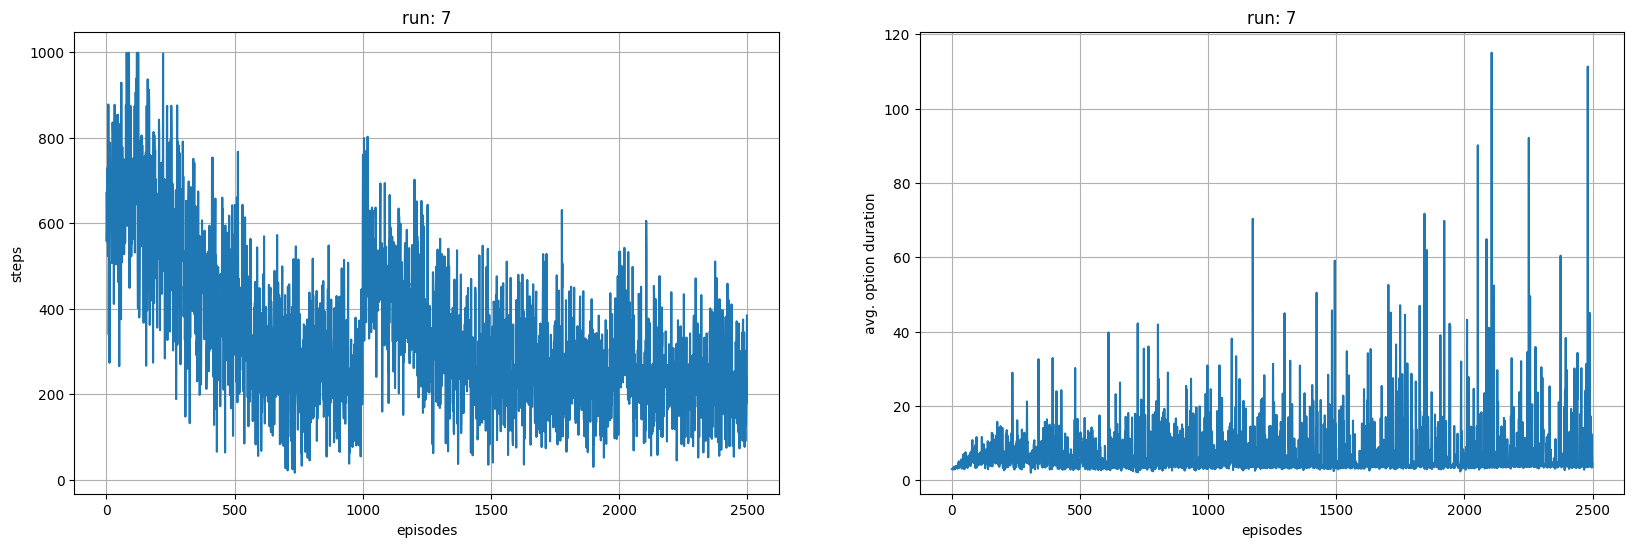

Goal:  (11, 5)
New goal:  (3, 6)
New goal:  (10, 6)
New goal:  (6, 2)


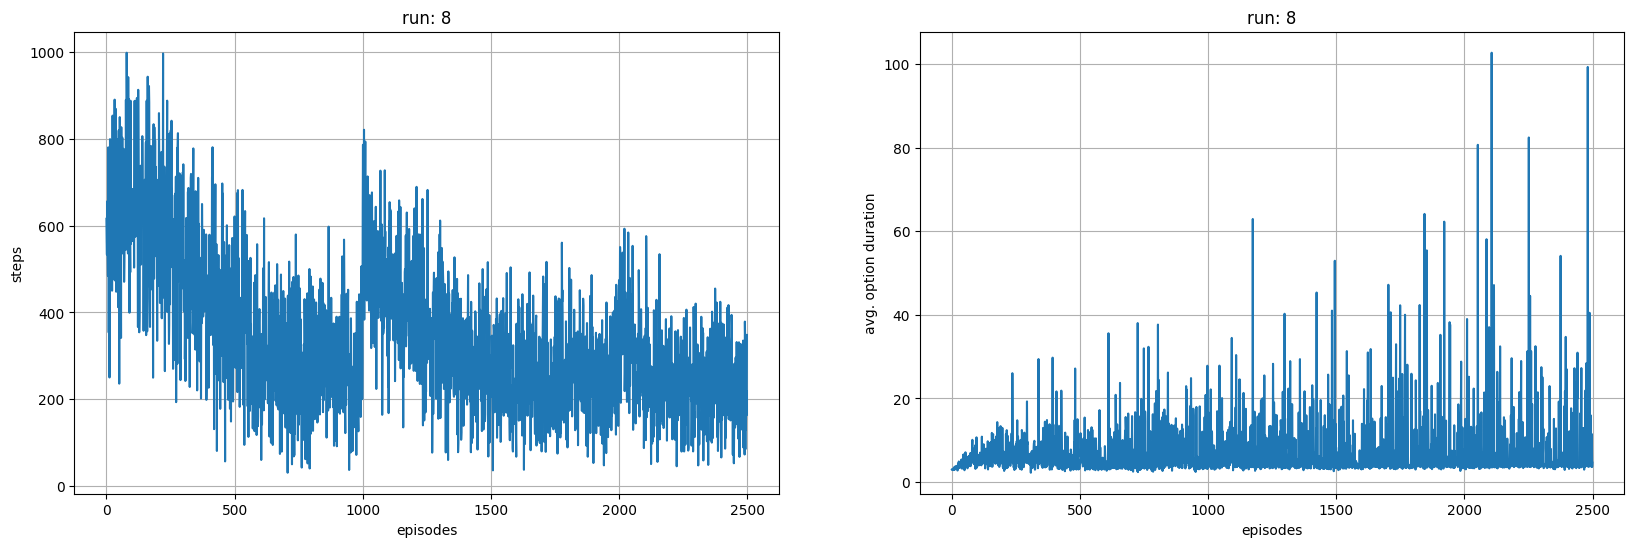

Goal:  (11, 5)
New goal:  (6, 2)
New goal:  (10, 6)
New goal:  (3, 6)


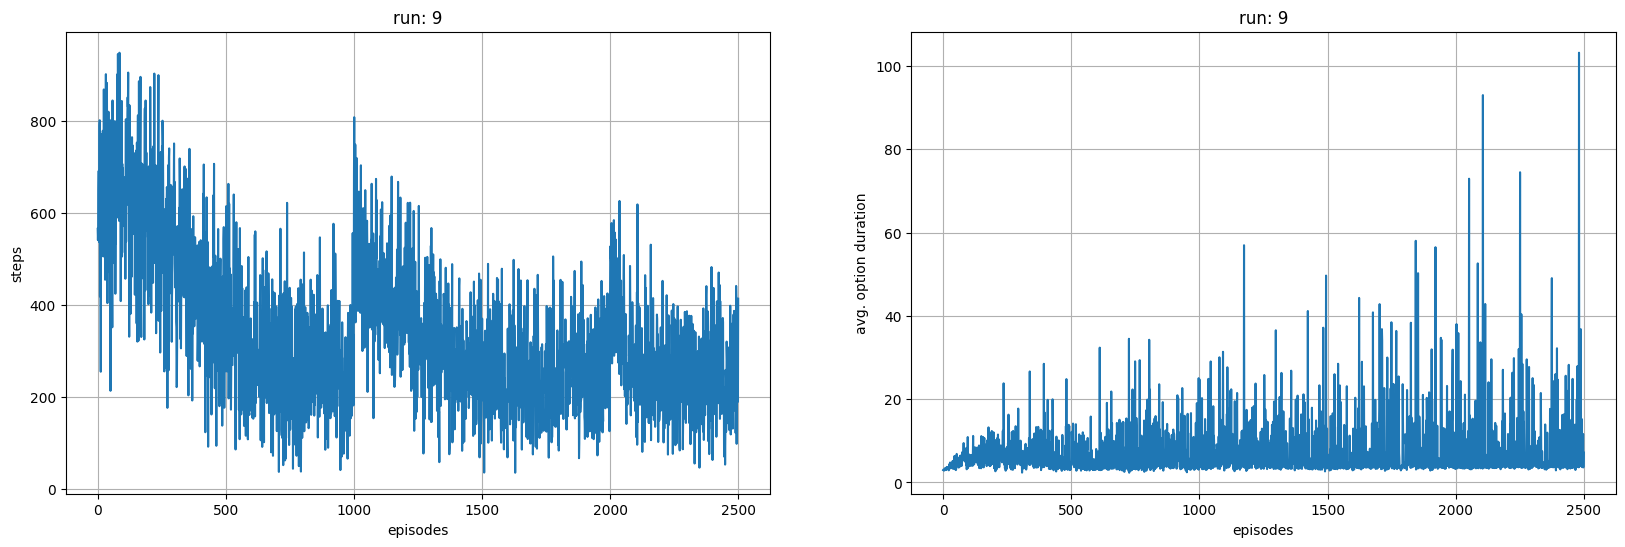

In [26]:
# Train Agent

rng = np.random.RandomState(1234)

#adding doorways
possible_next_goals =[(6,2), (3,6), (7,9), (10,6)]

# History of steps and average durations
history = np.zeros((nruns, nepisodes, 2))

option_terminations_list = []

for run in range(nruns):

    nstates = env.observation_space.shape[0]
    nactions = env.action_space.shape[0]

    # Following three belong to the Actor

    # 1. The intra-option policies - linear softmax functions
    option_policies = [SoftmaxPolicy(rng, lr_intra, nstates, nactions, temperature) for _ in range(noptions)]

    # 2. The termination function - linear sigmoid function
    option_terminations = [SigmoidTermination(rng, lr_term, nstates) for _ in range(noptions)]


    # 3. The epsilon-greedy policy over options
    policy_over_options = EpsGreedyPolicy(rng, nstates, noptions, epsilon)

    # Critic
    critic = Critic(lr_critic, discount, policy_over_options.Q_Omega_table, nstates, noptions, nactions)

    env.goal = (11,5)
    print('Goal: ', env.goal)

    c = 0
    for episode in range(nepisodes):

        # Change goal location after 1000 episodes
        # Comment it for not doing transfer experiments
        if episode%1000 == 0:
            env.goal = possible_next_goals[rng.choice(len(possible_next_goals))]
            print('New goal: ', env.goal)

        state = env.reset()

        option = policy_over_options.sample(state)
        # hardcoding actions according to options
        action = option_policies[option].sample(state)

        critic.cache(state, option, action)

        duration = 1
        option_switches = 0
        avg_duration = 0.0

        for step in range(nsteps):

            state, reward, done, _ = env.step(action)
            reward = reward + c

            # Termination might occur upon entering new state
            # if termination is true
            if option_terminations[option].sample(state):
                c = eta
                option = policy_over_options.sample(state)
                option_switches += 1
                avg_duration += (1.0 / option_switches) * (duration - avg_duration)
                duration = 1
            else:
                c = 0
            action = option_policies[option].sample(state)

            # Critic update
            critic.update_Qs(state, option, action, reward, done, option_terminations)

            # Intra-option policy update with baseline
            Q_U = critic.Q_U(state, option, action)
            Q_U = Q_U - critic.Q_Omega(state, option)
            option_policies[option].update(state, action, Q_U)

            # Termination condition update
            option_terminations[option].update(state, critic.A_Omega(state, option) + eta)

            duration += 1

            if done:
                break

        history[run, episode, 0] = step
        history[run, episode, 1] = avg_duration

    option_terminations_list.append(option_terminations)

    #Plot stuff
    plt.figure(figsize=(20, 6))
    plt.subplot(121)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('steps')
    plt.plot(np.mean(history[:run + 1, :, 0], axis=0))
    plt.grid(True)
    plt.subplot(122)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('avg. option duration')
    plt.plot(np.mean(history[:run + 1, :, 1], axis=0))
    plt.grid(True)
    plt.show()

In [27]:
for run in range(nruns):

    termination_maps = [env.occupancy.astype('float64') for _ in range(noptions)]

    for option in range(noptions):
        for i in range(13):
            for j in range(13):
                state = (i,j)
                if termination_maps[option][i, j] == 0:
                    termination_maps[option][i, j] = option_terminations_list[run][option].pmf(state)

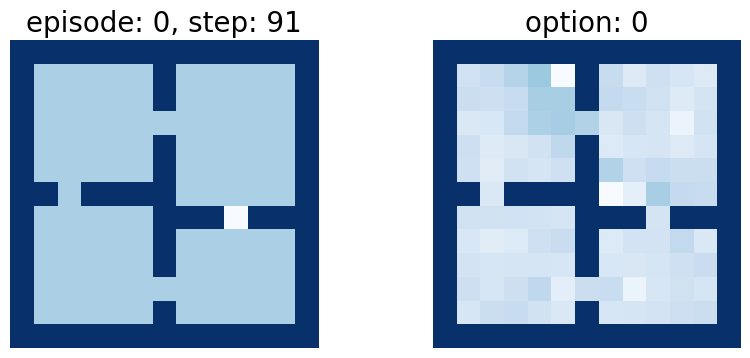

Goal reached!


In [28]:
# Test Agent

# Turn off exploration while testing
# Turn off exploration while testing
policy_over_options.epsilon = 0
for option in range(noptions):
    option_policies[option].temperature = 1e-10

env = FourRooms()

nepisodes = 1

rng = np.random.RandomState(1234)

for episode in range(nepisodes):

    state = env.reset()

    option = policy_over_options.sample(state)

    for step in range(nsteps):

        action = option_policies[option].sample(state)

        state, reward, done, _ = env.step(action)

        # Termination might occur upon entering new state
        if option_terminations[option].sample(state):
            option = policy_over_options.sample(state)

        clear_output(True)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('episode: {}, step: {}'.format(episode, step), fontsize=20)
        plt.imshow(env.render(), cmap='Blues', )
        plt.axis('off')
        plt.subplot(122)
        plt.title('option: %s' %option, fontsize=20)
        plt.imshow(termination_maps[option], cmap='Blues')
        plt.axis('off')
        plt.show()

        if done:
            break

    print("Goal reached!")
    sleep(2)